In [3]:
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [43]:
%load_ext pretty_jupyter

# Introduction

In diesem Notebook wenden wir Applied Machine Learning (AML) Techniken an, um effektive Strategien für personalisierte Kreditkarten-Werbekampagnen zu entwickeln. Unser Ziel ist es, mithilfe von Kunden- und Transaktionsdaten präzise Modelle zu erstellen, die die Wahrscheinlichkeit des Kreditkartenkaufs vorhersagen.

## Lib Importing


In [6]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from itables import init_notebook_mode
from datetime import datetime

init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

## Load the Data



In [7]:
account = pd.read_csv("account.csv", sep=";", dtype={"date": "str"})
account["date"] = pd.to_datetime(account["date"], format="%y%m%d")

card = pd.read_csv("card.csv", sep=";", dtype={"issued": "str"})
# Man kann die Zeit weglassen da immer 00:00:00
card["issued"] = pd.to_datetime(card["issued"].str[:6], format="%y%m%d")

client = pd.read_csv("client.csv", sep=";")
disp = pd.read_csv("disp.csv", sep=";")
district = pd.read_csv("district.csv", sep=";")

loan = pd.read_csv("loan.csv", sep=";", dtype={"date": "str"})
loan["date"] = pd.to_datetime(loan["date"], format="%y%m%d")


order = pd.read_csv("order.csv", sep=";")

trans = pd.read_csv("trans.csv", sep=";", dtype={"date": "str", "bank": "str"})
trans["date"] = pd.to_datetime(trans["date"], format="%y%m%d")
trans
# count 'NaN' in each column from trans

trans_id  account_id       date    type operation  amount  balance  \
0          695247        2378 1993-01-01  PRIJEM     VKLAD   700.0    700.0   
1          171812         576 1993-01-01  PRIJEM     VKLAD   900.0    900.0   
2          207264         704 1993-01-01  PRIJEM     VKLAD  1000.0   1000.0   
3         1117247        3818 1993-01-01  PRIJEM     VKLAD   600.0    600.0   
4          579373        1972 1993-01-02  PRIJEM     VKLAD   400.0    400.0   
...           ...         ...        ...     ...       ...     ...      ...   
1056315   3626622        2906 1998-12-31  PRIJEM       NaN    62.3  13729.4   
1056316   3627616        2935 1998-12-31  PRIJEM       NaN    81.3  19544.9   
1056317   3625403        2869 1998-12-31  PRIJEM       NaN    60.2  14638.2   
1056318   3626683        2907 1998-12-31  PRIJEM       NaN   107.5  23453.0   
1056319   3626540        2902 1998-12-31  PRIJEM       NaN   164.1  41642.9   

        k_symbol bank  account  
0            NaN  NaN      NaN  
1            NaN  NaN      NaN  
2            NaN  NaN      NaN  
3            NaN  NaN      NaN  
4            NaN  NaN      NaN  
...          ...  ...      ...  
1056315     UROK  NaN      NaN  
1056316     UROK  NaN      NaN  
1056317     UROK  NaN      NaN  
1056318     UROK  NaN      NaN  
1056319     UROK  NaN      NaN  

[1056320 rows x 10 columns]

## EDA

### Account

In [8]:
account

account_id  district_id         frequency       date
0            576           55  POPLATEK MESICNE 1993-01-01
1           3818           74  POPLATEK MESICNE 1993-01-01
2            704           55  POPLATEK MESICNE 1993-01-01
3           2378           16  POPLATEK MESICNE 1993-01-01
4           2632           24  POPLATEK MESICNE 1993-01-02
...          ...          ...               ...        ...
4495         124           55  POPLATEK MESICNE 1997-12-28
4496        3958           59  POPLATEK MESICNE 1997-12-28
4497         777           30  POPLATEK MESICNE 1997-12-28
4498        1573           63  POPLATEK MESICNE 1997-12-29
4499        3276            1  POPLATEK MESICNE 1997-12-29

[4500 rows x 4 columns]

### Card

In [9]:
card

card_id  disp_id     type     issued
0       1005     9285  classic 1993-11-07
1        104      588  classic 1994-01-19
2        747     4915  classic 1994-02-05
3         70      439  classic 1994-02-08
4        577     3687  classic 1994-02-15
..       ...      ...      ...        ...
887      125      694     gold 1998-12-26
888      674     4360  classic 1998-12-28
889      322     2063  classic 1998-12-28
890      685     4467  classic 1998-12-29
891      635     4083  classic 1998-12-29

[892 rows x 4 columns]

### Client

In [10]:
client

client_id  birth_number  district_id
0             1        706213           18
1             2        450204            1
2             3        406009            1
3             4        561201            5
4             5        605703            5
...         ...           ...          ...
5364      13955        456030            1
5365      13956        430406            1
5366      13968        680413           61
5367      13971        626019           67
5368      13998        535812           74

[5369 rows x 3 columns]

### Disp

In [11]:
disp

disp_id  client_id  account_id       type
0           1          1           1      OWNER
1           2          2           2      OWNER
2           3          3           2  DISPONENT
3           4          4           3      OWNER
4           5          5           3  DISPONENT
...       ...        ...         ...        ...
5364    13647      13955       11349      OWNER
5365    13648      13956       11349  DISPONENT
5366    13660      13968       11359      OWNER
5367    13663      13971       11362      OWNER
5368    13690      13998       11382      OWNER

[5369 rows x 4 columns]

### District

In [12]:
district

A1               A2               A3       A4  A5  A6  A7  A8  A9    A10  \
0    1      Hl.m. Praha           Prague  1204953   0   0   0   1   1  100.0   
1    2          Benesov  central Bohemia    88884  80  26   6   2   5   46.7   
2    3           Beroun  central Bohemia    75232  55  26   4   1   5   41.7   
3    4           Kladno  central Bohemia   149893  63  29   6   2   6   67.4   
4    5            Kolin  central Bohemia    95616  65  30   4   1   6   51.4   
..  ..              ...              ...      ...  ..  ..  ..  ..  ..    ...   
72  73            Opava    north Moravia   182027  17  49  12   2   7   56.4   
73  74  Ostrava - mesto    north Moravia   323870   0   0   0   1   1  100.0   
74  75           Prerov    north Moravia   138032  67  30   4   2   5   64.6   
75  76          Sumperk    north Moravia   127369  31  32  13   2   7   51.2   
76  77           Vsetin    north Moravia   148545   8  35  12   3   4   53.5   

      A11   A12   A13  A14    A15    A16  
0   12541  0.29  0.43  167  85677  99107  
1    8507  1.67  1.85  132   2159   2674  
2    8980  1.95  2.21  111   2824   2813  
3    9753  4.64  5.05  109   5244   5892  
4    9307  3.85  4.43  118   2616   3040  
..    ...   ...   ...  ...    ...    ...  
72   8746  3.33  3.74   90   4355   4433  
73  10673  4.75  5.44  100  18782  18347  
74   8819  5.38  5.66   99   4063   4505  
75   8369  4.73  5.88  107   3736   2807  
76   8909  4.01  5.56  113   3460   3590  

[77 rows x 16 columns]

### Loan

In [13]:
loan

loan_id  account_id       date  amount  duration  payments status
0       5314        1787 1993-07-05   96396        12    8033.0      B
1       5316        1801 1993-07-11  165960        36    4610.0      A
2       6863        9188 1993-07-28  127080        60    2118.0      A
3       5325        1843 1993-08-03  105804        36    2939.0      A
4       7240       11013 1993-09-06  274740        60    4579.0      A
..       ...         ...        ...     ...       ...       ...    ...
677     4989         105 1998-12-05  352704        48    7348.0      C
678     5221        1284 1998-12-05   52512        12    4376.0      C
679     6402        6922 1998-12-06  139488        24    5812.0      C
680     5346        1928 1998-12-06   55632        24    2318.0      C
681     6748        8645 1998-12-08  240900        60    4015.0      C

[682 rows x 7 columns]

### Order

In [14]:
order

order_id  account_id bank_to  account_to  amount  k_symbol
0        29401           1      YZ    87144583  2452.0      SIPO
1        29402           2      ST    89597016  3372.7      UVER
2        29403           2      QR    13943797  7266.0      SIPO
3        29404           3      WX    83084338  1135.0      SIPO
4        29405           3      CD    24485939   327.0          
...        ...         ...     ...         ...     ...       ...
6466     46334       11362      YZ    70641225  4780.0      SIPO
6467     46335       11362      MN    78507822    56.0          
6468     46336       11362      ST    40799850   330.0  POJISTNE
6469     46337       11362      KL    20009470   129.0          
6470     46338       11362      MN    61540514  5392.0      UVER

[6471 rows x 6 columns]

### Trans

In [15]:
trans

trans_id  account_id       date    type operation  amount  balance  \
0          695247        2378 1993-01-01  PRIJEM     VKLAD   700.0    700.0   
1          171812         576 1993-01-01  PRIJEM     VKLAD   900.0    900.0   
2          207264         704 1993-01-01  PRIJEM     VKLAD  1000.0   1000.0   
3         1117247        3818 1993-01-01  PRIJEM     VKLAD   600.0    600.0   
4          579373        1972 1993-01-02  PRIJEM     VKLAD   400.0    400.0   
...           ...         ...        ...     ...       ...     ...      ...   
1056315   3626622        2906 1998-12-31  PRIJEM       NaN    62.3  13729.4   
1056316   3627616        2935 1998-12-31  PRIJEM       NaN    81.3  19544.9   
1056317   3625403        2869 1998-12-31  PRIJEM       NaN    60.2  14638.2   
1056318   3626683        2907 1998-12-31  PRIJEM       NaN   107.5  23453.0   
1056319   3626540        2902 1998-12-31  PRIJEM       NaN   164.1  41642.9   

        k_symbol bank  account  
0            NaN  NaN      NaN  
1            NaN  NaN      NaN  
2            NaN  NaN      NaN  
3            NaN  NaN      NaN  
4            NaN  NaN      NaN  
...          ...  ...      ...  
1056315     UROK  NaN      NaN  
1056316     UROK  NaN      NaN  
1056317     UROK  NaN      NaN  
1056318     UROK  NaN      NaN  
1056319     UROK  NaN      NaN  

[1056320 rows x 10 columns]

## Transformations

In [16]:
data_frames = {}

### Account


In [17]:
# Frequency Transformation
account["frequency"] = account["frequency"].replace(
    {
        "POPLATEK MESICNE": "monthly issuance",
        "POPLATEK TYDNE": "weekly issuance",
        "POPLATEK PO OBRATU": "issuance after transaction",
    }
)

# Rename Column
account = account.rename(columns={"frequency": "issuance_statement_frequency"})

# Convert Date Column to datetime format
account["date"] = pd.to_datetime(account["date"])

# Assuming 'data_frames' is a dictionary of DataFrames
data_frames["account.csv"] = account

# Sample 5 random rows
account.sample(n=5)

account_id  district_id issuance_statement_frequency       date
427         4225           55             monthly issuance 1993-05-18
1837        2559           32             monthly issuance 1995-06-01
686         2167           16             monthly issuance 1993-08-08
270         3260           68             monthly issuance 1993-03-25
1352        3160           22             monthly issuance 1994-06-19

### Card

In [18]:
card["issued"] = pd.to_datetime(card["issued"], format="mixed")
data_frames["card.csv"] = card

### Client

In [19]:
# Funktion zur Bestimmung des Geschlechts und Berechnung des Geburtstags
def parse_details(birth_number):
    birth_number_str = str(
        birth_number
    )  # Konvertiere birth_number zu einem String, falls notwendig
    year_prefix = "19"
    month = int(birth_number_str[2:4])
    gender = "female" if month > 12 else "male"
    if gender == "female":
        month -= 50
    year = int(year_prefix + birth_number_str[:2])
    day = int(birth_number_str[4:6])
    birth_day = datetime(year, month, day)
    return gender, birth_day


# Berechnung des Alters basierend auf einem Basisjahr
def calculate_age(birth_date, base_date=datetime(1999, 12, 31)):
    return (
        base_date.year
        - birth_date.year
        - ((base_date.month, base_date.day) < (birth_date.month, birth_date.day))
    )


# Anwenden der Funktionen und Erstellen neuer Spalten
client["gender"], client["birth_day"] = zip(
    *client["birth_number"].apply(parse_details)
)
client["age"] = client["birth_day"].apply(calculate_age)

data_frames["client.csv"] = client

# Auswahl spezifischer Spalten für die finale DataFrame (optional, je nach Bedarf)
# Sample 5 random rows
client.sample(n=5)

client_id  birth_number  district_id  gender  birth_day  age
508         532        805903           27  female 1980-09-03   19
3083       3256        760718           49    male 1976-07-18   23
2864       3024        290308           60    male 1929-03-08   70
1922       2037        485826           69  female 1948-08-26   51
4515       4775        485722           59  female 1948-07-22   51

### Disp

In [20]:
data_frames["disp.csv"] = disp

# random sample
disp.sample(n=5)

disp_id  client_id  account_id       type
1346     1422       1422        1181      OWNER
1868     1979       1979        1633      OWNER
1603     1697       1697        1402      OWNER
3794     4008       4008        3315  DISPONENT
5319    12982      13290       10812      OWNER

### District


- A1 district_id/district code
- A2 district name
- A3 region
- A4 no. of inhabitants
- A5 no. of municipalities with inhabitants < 499
- A6 no. of municipalities with inhabitants 500-1999 A7 no. of municipalities with inhabitants 2000-9999
- A8 no. of municipalities with inhabitants >10000
- A9 no. of cities
- A10 ratio of urban inhabitants
- A11 average salary
- A12 unemploymant rate ’95
- A13 unemploymant rate ’96
- A14 no. of enterpreneurs per 1000 inhabitants
- A15 no. of commited crimes ’95
- A16 no. of commited crimes ’96

In [21]:
import pandas as pd

# Assuming 'district' is your pandas DataFrame

# Renaming and selecting columns
district = district.rename(
    columns={
        "A1": "district_id",
        "A2": "district_name",
        "A3": "region",
        "A4": "num_of_habitat",
        "A5": "num_of_small_town",
        "A6": "num_of_medium_town",
        "A7": "num_of_big_town",
        "A8": "num_of_bigger_town",
        "A9": "num_of_city",
        "A10": "ratio_of_urban",
        "A11": "average_salary",
        "A12": "unemploy_rate95",
        "A13": "unemploy_rate96",
        "A14": "n_of_enterpren_per1000_inhabit",
        "A15": "no_of_crimes95",
        "A16": "no_of_crimes96",
    }
)[
    [
        "district_id",
        "district_name",
        "region",
        "num_of_habitat",
        "num_of_small_town",
        "num_of_medium_town",
        "num_of_big_town",
        "num_of_bigger_town",
        "num_of_city",
        "ratio_of_urban",
        "average_salary",
        "unemploy_rate95",
        "unemploy_rate96",
        "n_of_enterpren_per1000_inhabit",
        "no_of_crimes95",
        "no_of_crimes96",
    ]
]

data_frames["district.csv"] = district

district.sample(n=5)
district

district_id    district_name           region  num_of_habitat  \
0             1      Hl.m. Praha           Prague         1204953   
1             2          Benesov  central Bohemia           88884   
2             3           Beroun  central Bohemia           75232   
3             4           Kladno  central Bohemia          149893   
4             5            Kolin  central Bohemia           95616   
..          ...              ...              ...             ...   
72           73            Opava    north Moravia          182027   
73           74  Ostrava - mesto    north Moravia          323870   
74           75           Prerov    north Moravia          138032   
75           76          Sumperk    north Moravia          127369   
76           77           Vsetin    north Moravia          148545   

    num_of_small_town  num_of_medium_town  num_of_big_town  \
0                   0                   0                0   
1                  80                  26                6   
2                  55                  26                4   
3                  63                  29                6   
4                  65                  30                4   
..                ...                 ...              ...   
72                 17                  49               12   
73                  0                   0                0   
74                 67                  30                4   
75                 31                  32               13   
76                  8                  35               12   

    num_of_bigger_town  num_of_city  ratio_of_urban  average_salary  \
0                    1            1           100.0           12541   
1                    2            5            46.7            8507   
2                    1            5            41.7            8980   
3                    2            6            67.4            9753   
4                    1            6            51.4            9307   
..                 ...          ...             ...             ...   
72                   2            7            56.4            8746   
73                   1            1           100.0           10673   
74                   2            5            64.6            8819   
75                   2            7            51.2            8369   
76                   3            4            53.5            8909   

   unemploy_rate95  unemploy_rate96  n_of_enterpren_per1000_inhabit  \
0             0.29             0.43                             167   
1             1.67             1.85                             132   
2             1.95             2.21                             111   
3             4.64             5.05                             109   
4             3.85             4.43                             118   
..             ...              ...                             ...   
72            3.33             3.74                              90   
73            4.75             5.44                             100   
74            5.38             5.66                              99   
75            4.73             5.88                             107   
76            4.01             5.56                             113   

   no_of_crimes95  no_of_crimes96  
0           85677           99107  
1            2159            2674  
2            2824            2813  
3            5244            5892  
4            2616            3040  
..            ...             ...  
72           4355            4433  
73          18782           18347  
74           4063            4505  
75           3736            2807  
76           3460            3590  

[77 rows x 16 columns]

In [22]:
# find the ? in the district dataframe
district[district.isin(["?"]).any(axis=1)]

district_id district_name         region  num_of_habitat  \
68           69       Jesenik  north Moravia           42821   

    num_of_small_town  num_of_medium_town  num_of_big_town  \
68                  4                  13                5   

    num_of_bigger_town  num_of_city  ratio_of_urban  average_salary  \
68                   1            3            48.4            8173   

   unemploy_rate95  unemploy_rate96  n_of_enterpren_per1000_inhabit  \
68               ?             7.01                             124   

   no_of_crimes95  no_of_crimes96  
68              ?            1358

In [23]:
# replace the ? with NaN
district = district.replace("?", np.nan)

In [24]:
# replace the NaN with the mean of the column no_of_crimes95 and unemploy_rate95
district["no_of_crimes95"] = district["no_of_crimes95"].astype(float)
district["unemploy_rate95"] = district["unemploy_rate95"].astype(float)
district["no_of_crimes95"] = district["no_of_crimes95"].fillna(
    district["no_of_crimes95"].mean()
)
district["unemploy_rate95"] = district["unemploy_rate95"].fillna(
    district["unemploy_rate95"].mean()
)
# check if there are still NaN values in no_of_crimes95 and unemploy_rate95
district[district.isin([np.nan]).any(axis=1)]

Empty DataFrame
Columns: [district_id, district_name, region, num_of_habitat, num_of_small_town, num_of_medium_town, num_of_big_town, num_of_bigger_town, num_of_city, ratio_of_urban, average_salary, unemploy_rate95, unemploy_rate96, n_of_enterpren_per1000_inhabit, no_of_crimes95, no_of_crimes96]
Index: []

### Loan

In [25]:
# Convert the 'date' column to datetime format
loan["date"] = pd.to_datetime(loan["date"], format="mixed")

# Mutate the 'status' column based on conditions
loan["status"] = loan["status"].map(
    {
        "A": "contract finished",
        "B": "finished contract, loan not paid",
        "C": "running contract",
        "D": "client in debt",
    }
)

# Group by 'account_id', calculate the number of loans, and sort the results
num_of_loan_df = (
    loan.groupby("account_id")
    .size()
    .reset_index(name="num_of_loan")
    .sort_values(by="num_of_loan", ascending=False)
)

# Display the resulting DataFrame
num_of_loan_df

account_id  num_of_loan
0             2            1
457        7890            1
449        7795            1
450        7815            1
451        7819            1
..          ...          ...
229        4079            1
230        4081            1
231        4099            1
232        4116            1
681       11362            1

[682 rows x 2 columns]

In [26]:
# Perform an inner join between 'loan' and 'num_of_loan_df' on 'account_id'
loan = pd.merge(loan, num_of_loan_df, on="account_id", how="inner")

# Assign the resulting DataFrame to a dictionary for storage
data_frames["loan.csv"] = loan

# Sample 5 random rows from the joined DataFrame
loan.sample(n=100)

loan_id  account_id       date  amount  duration  payments  \
346     6415        6950 1997-02-12  475680        48    9910.0   
461     4990         110 1997-09-08  162576        36    4516.0   
331     6142        5591 1997-01-21  221880        60    3698.0   
104     6150        5622 1994-11-02   83016        12    6918.0   
637     5893        4467 1998-08-03   86184        36    2394.0   
..       ...         ...        ...     ...       ...       ...   
559     6568        7713 1998-02-25  220440        60    3674.0   
325     6805        8972 1996-12-21   45024        48     938.0   
499     6468        7176 1997-11-30  203940        60    3399.0   
624     7200       10799 1998-07-11   31140        60     519.0   
553     5124         785 1998-02-12  156096        36    4336.0   

                status  num_of_loan  
346   running contract            1  
461   running contract            1  
331   running contract            1  
104  contract finished            1  
637   running contract            1  
..                 ...          ...  
559   running contract            1  
325   running contract            1  
499   running contract            1  
624   running contract            1  
553   running contract            1  

[100 rows x 8 columns]

### Order


In [27]:
# Assuming 'order' and 'account' DataFrames are already loaded

# Correctly map and fill missing values in 'k_symbol' column
order["k_symbol"] = (
    order["k_symbol"]
    .map({"POJISTNE": "Insurance Payment", "SIPO": "Household", "UVER": "Loan Payment"})
    .fillna("UNKNOWN")
)

# Merge with 'account_id_df' to ensure all accounts are represented
order = pd.merge(account[["account_id"]], order, on="account_id", how="left")

# After merging, fill missing values that may have been introduced
order["k_symbol"] = order["k_symbol"].fillna("UNKNOWN")
order["amount"] = order["amount"].fillna(0)
order["has_order"] = ~order.isna().any(axis=1)

# Aggregate 'amount' information
aggregated_amount = (
    order.groupby("account_id")
    .agg(
        sum_amount=("amount", "sum"),
        mean_amount=("amount", "mean"),
        median_amount=("amount", "median"),
        min_amount=("amount", "min"),
        max_amount=("amount", "max"),
        num_of_orders=("amount", lambda x: (x != 0).sum()),
    )
    .reset_index()
)
aggregated_amount["has_order"] = aggregated_amount["sum_amount"] != 0

# Create dummies for 'k_symbol' and ensure aggregation by 'account_id'
dummies_k_symbol = pd.get_dummies(
    order[["account_id", "k_symbol"]], columns=["k_symbol"], prefix="", prefix_sep=""
)
dummies_k_symbol = dummies_k_symbol.groupby("account_id").sum().reset_index()

# Merge 'aggregated_amount' and 'dummies_k_symbol'
merged_order = pd.merge(
    aggregated_amount, dummies_k_symbol, on="account_id", how="left"
)

# Assuming data_frames is a dictionary for storing DataFrames
data_frames["order.csv"] = merged_order

# Sample 5 random rows from the merged DataFrame
merged_order.sample(n=5)

account_id  sum_amount   mean_amount  median_amount  min_amount  \
3140        3302      2005.0    668.333333          572.0        57.0   
2000        2097         0.0      0.000000            0.0         0.0   
2603        2736      4604.0   4604.000000         4604.0      4604.0   
2216        2334     12720.0   6360.000000         6360.0      2013.0   
2304        2424     14138.0  14138.000000        14138.0     14138.0   

      max_amount  num_of_orders  has_order  Household  Insurance Payment  \
3140      1376.0              3       True          1                  1   
2000         0.0              0      False          0                  0   
2603      4604.0              1       True          1                  0   
2216     10707.0              2       True          1                  0   
2304     14138.0              1       True          1                  0   

      Loan Payment  UNKNOWN  
3140             0        1  
2000             0        1  
2603             0        0  
2216             1        0  
2304             0        0

### Trans


In [28]:
# Convert 'date' from string to datetime
trans["date"] = pd.to_datetime(trans["date"])

# Update 'type' column
trans["type"] = trans["type"].replace({"PRIJEM": "credit", "VYDAJ": "withdrawal"})

# Update 'operation' column
trans["operation"] = trans["operation"].replace(
    {
        "VYBER KARTOU": "credit card withdrawal",
        "VKLAD": "credit in cash",
        "PREVOD Z UCTU": "collection from another bank",
        "VYBER": "cash withdrawal",
        "PREVOD NA UCET": "remittance to another bank",
    }
)

# Update 'k_symbol' column
trans["k_symbol"] = trans["k_symbol"].replace(
    {
        "POJISTNE": "insurance payment",
        "SLUZBY": "statement payment",
        "UROK": "interest credited",
        "SANKC. UROK": "sanction interest if negative balance",
        "SIPO": "household payment",
        "DUCHOD": "pension credited",
        "UVER": "loan payment",
    }
)

# Assign to a dictionary if needed (similar to list assignment in R)

data_frames["trans.csv"] = trans

# Sample 5 random rows from the DataFrame
trans.sample(n=1000)
trans

trans_id  account_id       date    type       operation  amount  \
0          695247        2378 1993-01-01  credit  credit in cash   700.0   
1          171812         576 1993-01-01  credit  credit in cash   900.0   
2          207264         704 1993-01-01  credit  credit in cash  1000.0   
3         1117247        3818 1993-01-01  credit  credit in cash   600.0   
4          579373        1972 1993-01-02  credit  credit in cash   400.0   
...           ...         ...        ...     ...             ...     ...   
1056315   3626622        2906 1998-12-31  credit             NaN    62.3   
1056316   3627616        2935 1998-12-31  credit             NaN    81.3   
1056317   3625403        2869 1998-12-31  credit             NaN    60.2   
1056318   3626683        2907 1998-12-31  credit             NaN   107.5   
1056319   3626540        2902 1998-12-31  credit             NaN   164.1   

         balance           k_symbol bank  account  
0          700.0                NaN  NaN      NaN  
1          900.0                NaN  NaN      NaN  
2         1000.0                NaN  NaN      NaN  
3          600.0                NaN  NaN      NaN  
4          400.0                NaN  NaN      NaN  
...          ...                ...  ...      ...  
1056315  13729.4  interest credited  NaN      NaN  
1056316  19544.9  interest credited  NaN      NaN  
1056317  14638.2  interest credited  NaN      NaN  
1056318  23453.0  interest credited  NaN      NaN  
1056319  41642.9  interest credited  NaN      NaN  

[1056320 rows x 10 columns]

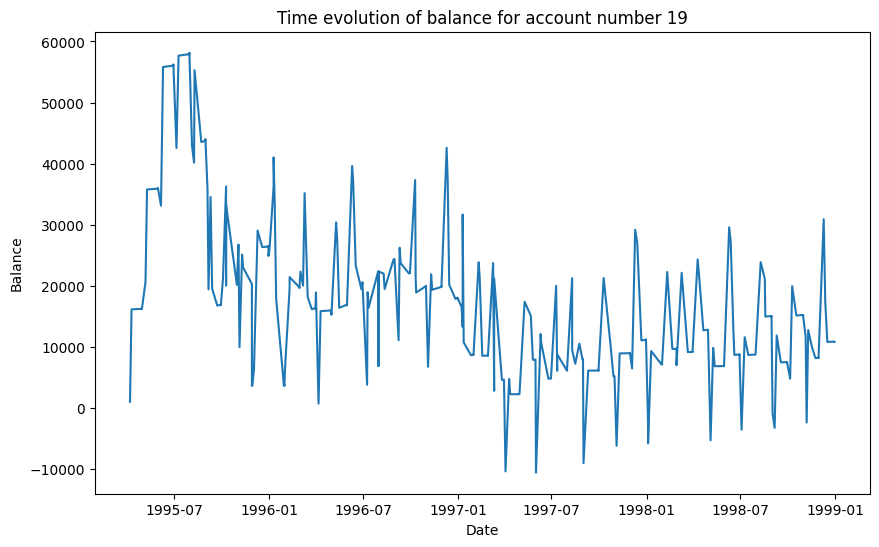

In [29]:
# Plot Zeitliche Entwicklung des Konto-Saldos für die Konto nummer 19
account_19 = trans[trans["account_id"] == 19].copy()  # Create a copy of the DataFrame
# Ensure the date column is in datetime format
account_19["date"] = pd.to_datetime(account_19["date"])

# Sort the values by date
account_19 = account_19.sort_values("date")

plt.figure(figsize=(10, 6))
plt.plot(account_19["date"], account_19["balance"])
plt.title("Time evolution of balance for account number 19")
plt.xlabel("Date")
plt.ylabel("Balance")
plt.show()

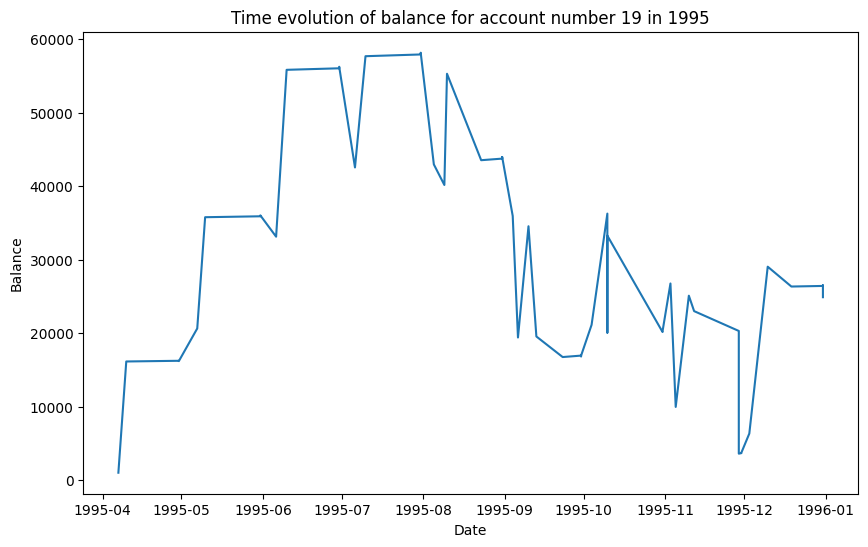

In [30]:
# zoom the year 1995 of the plot
account_19_1995 = account_19[account_19["date"].dt.year == 1995]
# plot it
plt.figure(figsize=(10, 6))
plt.plot(account_19_1995["date"], account_19_1995["balance"])
plt.title("Time evolution of balance for account number 19 in 1995")
plt.xlabel("Date")
plt.ylabel("Balance")
plt.show()

Wee see that there is a steep line in 1995-10 so there are two transactions, this we have to clean.

## D&Q

In [31]:
# Check for missing values in each DataFrame
for df_name, df in data_frames.items():
    print(f"Missing values in {df_name}:")
    print(df.isna().sum().sum())  # Sum of all missing values in the DataFrame

Missing values in account.csv:
0
Missing values in card.csv:
0
Missing values in client.csv:
0
Missing values in disp.csv:
0
Missing values in district.csv:
0
Missing values in loan.csv:
0
Missing values in order.csv:
0
Missing values in trans.csv:
2208738


## Dropping of Junior Cards that are not on the edge to a normal card


In [40]:
data_frames.keys()

dict_keys(['account.csv', 'card.csv', 'client.csv', 'disp.csv', 'district.csv', 'loan.csv', 'order.csv', 'trans.csv'])

In [ ]:
# join the dataframes


In [ ]:
!jupytext --to notebook clean-tech-rag.py
# commxand with os
os.system("jupytext --to notebook AML_MC.py")

In [ ]:
!jupyter nbconvert --to html --template pj "clean-tech-rag.ipynb"
# command with os
os.system("jupyter nbconvert --to html --template pj AML_MC.ipynb")